In [64]:
import sys
sys.path.insert(0, '/usr/users/vogg/FairMOT/src')
sys.path.insert(0, '/usr/users/vogg/FairMOT/src/lib')
sys.path.insert(0, '/opt/conda/envs/mktrack/lib/python3.8/site-packages')
sys.path.insert(0, '/usr/users/vogg/.conda/envs/fairmot/lib/python3.8/site-packages')
sys.path.insert(0, '/usr/users/vogg/FairMOT/DCNv2')


In [65]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function


import numpy as np
import math
import matplotlib.pyplot as plt
from tracking_utils.kalman_filter import KalmanFilterGeneral
from tracker.jipda import JIPDATracker
from tracker.single_target_tracker import MonkeyTracker

## Kalman Filter (general implementation)

In [32]:
kf = KalmanFilterGeneral(2)

In [33]:
mn, cv = kf.initiate(np.array([0.9, 2.5]), 2)
cv

array([[0.04, 0.  , 0.  , 0.  ],
       [0.  , 0.04, 0.  , 0.  ],
       [0.  , 0.  , 1.  , 0.  ],
       [0.  , 0.  , 0.  , 1.  ]])

In [34]:
mn

array([0.9, 2.5, 0. , 0. ])

In [35]:
mn, cv = kf.predict(mn, cv, 2)

In [36]:
cv

array([[1.05      , 0.        , 1.        , 0.        ],
       [0.        , 1.05      , 0.        , 1.        ],
       [1.        , 0.        , 1.00015625, 0.        ],
       [0.        , 1.        , 0.        , 1.00015625]])

In [37]:
kf.project(mn, cv, 2)

(array([0.9, 2.5]),
 array([[1.06, 0.  ],
        [0.  , 1.06]]))

In [38]:
meas = np.array([1.7, 2.3])
kf.update(mn, cv, meas, 2)

(array([ 1.69245283,  2.30188679,  0.75471698, -0.18867925]),
 array([[0.00990566, 0.        , 0.00943396, 0.        ],
        [0.        , 0.00990566, 0.        , 0.00943396],
        [0.00943396, 0.        , 0.05676002, 0.        ],
        [0.        , 0.00943396, 0.        , 0.05676002]]))

In [11]:
meas = np.zeros((25,2))
meas[0] = [1, 1]



In [12]:
prior = meas[0]

for i, row in enumerate(meas):
    meas[i] = prior + [1, 1] + 2 * (np.random.rand(2) - 0.5)
    prior = meas[i]

In [13]:
def euclidean_d(row1, row2):
    distance = 0.0
    for i in range(len(row1)):
        distance += (row1[i] - row2[i])**2
    return math.sqrt(distance)

def find_nn(point, meas, clutter):
    distance = 10000
    for row in clutter:
        dist = euclidean_d(point, row)
        if dist < distance:
            distance = dist
            nn = row
            
    dist = euclidean_d(point, meas)
    if dist < distance:
        nn = meas
            
    return nn

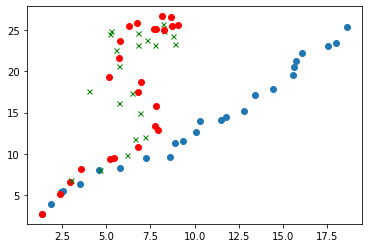

In [61]:
np.random.seed(122)

plt.plot(meas[:,0], meas[:,1], 'o')

mn, cv = kf.initiate(meas[0], 5)

for i, line in enumerate(meas[1:]):
    mn, cv = kf.predict(mn, cv, 5)
    plt.plot(mn[0], mn[1], 'ro')
    clutter = 25 * np.random.rand(60,2) + 1
    #print("mean: ", mn[:2], ", Det:", line)
    nn = find_nn(mn[:2], line, clutter)
    if any(nn != line):
        plt.plot(nn[0], nn[1], 'gx', markersize = 5)
    mn, cv = kf.update(mn, cv, nn, 5)

## Structured arrays

In [3]:
_track_dtype = np.dtype([
            ('target', 'O'),  # current estimate, uses specified Tracker, e.g. splines
            ('ex', 'f4'),  # the existence probability of the track, used for trimming
        ])
_tracks = np.zeros(0, dtype=_track_dtype)

In [4]:
_tracks


array([], dtype=[('target', 'O'), ('ex', '<f4')])

In [5]:
candidate_dtype = np.dtype([
    ('time_s', 'f8'),       # time stamp of the candidate
    ('center', 'f4', 2),    # center of the candidate
    ('box', 'f4', 2),       # box of the candidate
    ('birth_prob', 'f4'),   # birth probability
])

In [6]:
candidate_dtype

dtype([('time_s', '<f8'), ('center', '<f4', (2,)), ('box', '<f4', (2,)), ('birth_prob', '<f4')])

In [73]:
_candidates = np.zeros(1, dtype=candidate_dtype)

In [74]:
_candidates

array([(0., [0., 0.], [0., 0.], 0.)],
      dtype=[('time_s', '<f8'), ('center', '<f4', (2,)), ('box', '<f4', (2,)), ('birth_prob', '<f4')])

In [75]:
_candidates[0] = (0.1, (5,2), (3,3), 0.9)

In [76]:
_candidates

array([(0.1, [5., 2.], [3., 3.], 0.9)],
      dtype=[('time_s', '<f8'), ('center', '<f4', (2,)), ('box', '<f4', (2,)), ('birth_prob', '<f4')])

## Monkey tracker

In [19]:
init_mean = np.array([0.9, 2.5, 0, 0])
init_box = np.array([0.3, 0.5, 0, 0])
std_pos = [1/5]*2
std_vel = [1]*2
std = np.r_[std_pos, std_vel]
covariance = np.diag(np.square(std))
mt = MonkeyTracker(init_mean, init_box, covariance)

In [20]:
covariance

array([[0.04, 0.  , 0.  , 0.  ],
       [0.  , 0.04, 0.  , 0.  ],
       [0.  , 0.  , 1.  , 0.  ],
       [0.  , 0.  , 0.  , 1.  ]])

In [21]:
mt.predict()

(array([0.9, 2.5, 0. , 0. ]),
 array([[1.0425    , 0.        , 1.        , 0.        ],
        [0.        , 1.0425    , 0.        , 1.        ],
        [1.        , 0.        , 1.00003906, 0.        ],
        [0.        , 1.        , 0.        , 1.00003906]]))

In [28]:
meas = np.array([1.7, 2.3])
R = covariance[:2,:2]

In [29]:
mt.correct(meas, R)

H:  (2, 4)
cov:  (4, 4)
R:  (2, 2)


In [30]:
mt.get_position()

array([ 1.6704388 ,  2.3073903 ,  0.73903002, -0.18475751])

In [31]:
mt.get_cov()

array([[0.03852194, 0.        , 0.0369515 , 0.        ],
       [0.        , 0.03852194, 0.        , 0.0369515 ],
       [0.0369515 , 0.        , 0.07625153, 0.        ],
       [0.        , 0.0369515 , 0.        , 0.07625153]])

## JIPDA

In [6]:
tracker = JIPDATracker()

In [7]:
tracker.predict()

In [8]:
tracker._tracks

array([], dtype=[('target', 'O'), ('ex', '<f4')])

In [79]:
standard_cov = np.array([[50, 0.5],[0.5,50]])

In [68]:
meas = np.dtype([
    ('center', 'f4', 2), 
    ('center_cov', 'f4', (2,2)),
    ('box', 'f4', 2)])
ex = np.array([([0, 1], standard_cov, None), ([0, 2], standard_cov, None)], 
              dtype = meas)

ex['center']

array([[0., 1.],
       [0., 2.]], dtype=float32)

In [69]:
test = np.arange(36).reshape(9,4)


In [70]:
meas2 = np.dtype([
    ('time_s', 'f8'),
    ('data_points', 'O'),
    ('gt_box', 'O'),
    ('sample_id', 'i4')
])
ex = np.array([(1, np.array((line[:2], standard_cov, line[2:4]), dtype = meas), 0,5) 
               for line in test], dtype = meas2)

In [71]:
len(ex['data_points'])

9

In [72]:
ex['data_points'][1]['center']

array([4., 5.], dtype=float32)

In [73]:
ex2['data_points'][0][0]

NameError: name 'ex2' is not defined

In [83]:
tester_dtype = np.dtype([
    ('center', 'f4', 2), 
    ('center_cov', 'f4', (2,2))])

class Tester:
    def __init__(self, avg, cov):
        self.avg = avg
        self.cov = cov
        
    def get_avg(self):
        return self.avg
    
    def get_dtype(self):
        return tester_dtype
    

tester1 = Tester(np.array([5,1]), np.array([[500,1],[2,500]]))
tester2 = Tester(np.array([5,8]), np.array([[3,4],[5,6]]))



In [49]:
components = np.zeros((1, 2), 
                      dtype=np.object)

In [50]:
components[0].shape

(2,)

In [51]:
components[0][0] = tester1

In [22]:
components[0][1] = tester2

In [30]:
print([elem.get_avg() for elem in components[0]])

[array([2, 1]), array([5, 8])]


In [26]:
import numpy

class Atom(object):
    def atoms_method(self, foo, bar):
        #...with foo and bar being arrays of Paramsof length m & n
        atom_out = foo + bar
        return atom_out


array = numpy.ndarray((10,),dtype=numpy.object)

for i in range(10):
    array[i] = Atom()

for i in range(10):
    print(array[i].atoms_method(i, 5))

5
6
7
8
9
10
11
12
13
14


In [75]:
tester1

In [76]:
import scipy.stats

In [77]:
scipy.stats.multivariate_normal(np.zeros(2), tester1.cov).pdf(5*np.ones(2))

0.0004795818293479214

In [84]:
scipy.stats.multivariate_normal(np.zeros(2), tester1.cov).pdf(np.array([1148.7,706.25]) - 
                                                              np.array([1148.8,698.89]))

0.0003015232230417489

In [ ]:
scipy.stats.multivariate_normal(np.zeros(2), np.linalg.multi_dot((self.H, self.cov, self.H.T))).pdf(z_in - np.dot(self.H, self.mean))

In [98]:
new_candidates = np.array([[7,8],[9, 8], [1.1,2.1]])
for i in range(len(new_candidates)):
    print(np.array([[1,2],[3,4]]) - new_candidates[i])
    dists = min(np.linalg.norm(np.array([[1,2],[3,4]]) - new_candidates[i], axis = 1))
    print(dists)

[[-6. -6.]
 [-4. -4.]]
5.656854249492381
[[-8. -6.]
 [-6. -4.]]
7.211102550927978
[[-0.1 -0.1]
 [ 1.9  1.9]]
0.14142135623730964
